# TLS Rotating frame

In [54]:
import numpy as np
from qocag import grape_schroedinger_discrete
from qocag import TargetStateInfidelity,Robustness
from qocag import ControlVariation,generate_save_file_path,ControlBandwidthMax
from qocag import LBFGSB,Adam
total_time_steps=10
#Toltal number of descretized time pieces
target_states=np.array( [0,1])
#Target state is |1>
cost1=TargetStateInfidelity(target_states=target_states)
cost2=Robustness(robust_operator=np.array([[-1,0],[0,1]]),delta=1e-7,cost_multiplier=2)
costs=[cost1,cost2]
total_time=10
#Evolution time is 10 ns
H0=0
#Qubit frequency is 1GHZ
H_controls=[np.array([[0,1],[1,0]])]
#Control Hamiltonian is sigma_x
initial_states=np.array([1,0])
#Initial state is |0>
# result=np.load("./out/00000_qubit01.npy",allow_pickle=True).item()
# initial_control=result["control_iter"][-1]
times = np.linspace(0, total_time, total_time_steps+1)
times=np.delete(times, [len(times) - 1])
initial_control=(np.pi/2/total_time)*np.array([np.cos(2*np.pi*times)])/np.array([np.cos(2*np.pi*times)])
result1=grape_schroedinger_discrete(total_time_steps,
                                costs, total_time, H0, H_controls,
                                initial_states,max_iteration_num=1,
                                optimizer=Adam(),initial_controls=result1.control_iter[-1],mode="AD")

iter   |   total error  |       cost0      |       cost1      |   grads_l2  
  1    | 1.93478847e-06 |  1.90814311e-06  |  2.66453526e-08  |  8.76118975e-03  


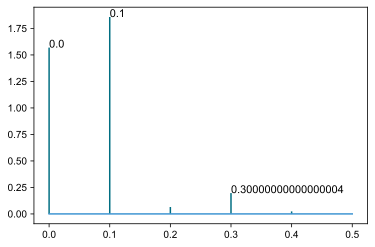

In [55]:
times = np.linspace(0, total_time, total_time_steps+1)
times=np.delete(times, [len(times) - 1])
#the pulse for minimum total_error among iterations
best_controls=result1.control_iter[-1]
from numpy.fft import rfft,rfftfreq
import matplotlib.pyplot as plt
freq = rfftfreq(len(times), times[1]-times[0])
fourier = np.abs(rfft(best_controls[0]))
freq = rfftfreq(len(times), times[1]-times[0])
max_index = np.argpartition(abs(fourier), -3)[-3:]
fig,ax=plt.subplots()
ax.stem(freq, fourier, markerfmt=' ', label='')
for index in max_index:
    ax.annotate('{}'.format(freq[index]), xy=(freq[index], fourier[index]))

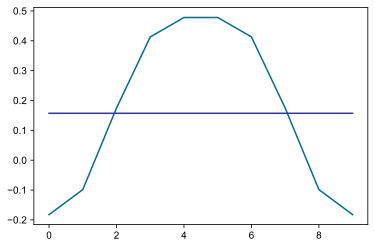

In [56]:
plt.plot(result1.control_iter[-1][0])
plt.plot(initial_control[0])

In [57]:
grape_schroedinger_discrete(total_time_steps,
                                costs, total_time, H0, H_controls,
                                initial_states,max_iteration_num=1,
                                optimizer=Adam(),initial_controls=best_controls,mode="AD")

iter   |   total error  |       cost0      |       cost1      |   grads_l2  
  1    | 1.93478847e-06 |  1.90814311e-06  |  2.66453526e-08  |  8.76118975e-03  


In [58]:
#detunning
H0=np.array([[1,0],[0,-1]])*((0.01)*2*np.pi/2)

In [59]:
H0=0
import qutip as qt
fluc=np.linspace(-10,10,101)*np.pi*1e-3
infidelities=np.zeros(len(fluc))
infidelities_robust=np.zeros(len(fluc))
for i in range(len(fluc)):
    resolution=10
    qt_H0=qt.Qobj(H0+fluc[i]*np.array([[-1,0],[0,1]]))
    qt_Hc1=qt.Qobj(H_controls[0])
    qt_is=qt.Qobj(initial_states)
    qt_N=10
    qt_t=total_time
    qt_tlist=np.linspace(0,qt_t,qt_N*resolution)
    qt_c1 = np.array([])
    for value in initial_control[0]: 
        for j in range(resolution):
             qt_c1 = np.append(qt_c1,value)
    qt_H=[qt_H0,[qt_Hc1,qt_c1]]
    p1=qt.Qobj(target_states).proj()
    e_ops=[p1]
    result=qt.sesolve(qt_H,qt_is,qt_tlist,e_ops)
    infidelities[i]=1-max(result.expect[0])
    
    qt_c1 = np.array([])
    for value in best_controls[0]: 
        for j in range(resolution):
             qt_c1 = np.append(qt_c1,value)
    qt_H=[qt_H0,[qt_Hc1,qt_c1]]
    p1=qt.Qobj(target_states).proj()
    e_ops=[p1]
    result=qt.sesolve(qt_H,qt_is,qt_tlist,e_ops)
    infidelities_robust[i]=1-max(result.expect[0])


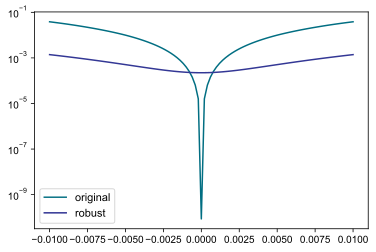

In [60]:
fig,ax=plt.subplots()
ax.plot(fluc/np.pi,infidelities,label='original')
ax.plot(fluc/np.pi,infidelities_robust,label='robust')
ax.set_yscale('log')
ax.legend()

In [62]:
total_time_steps=400
resolution=int(total_time_steps/10)
envolope=np.array([])
for value in best_controls[0]: 
    for j in range(resolution):
        envolope = np.append(envolope,value)
times = np.linspace(0, total_time, total_time_steps+1)
times=np.delete(times, [len(times) - 1])
best_total_control1=envolope*np.cos(5*2*np.pi*times)

In [63]:
len(best_controls[0])

10

In [122]:
H0=np.array([[-1,0],[0,1]])*((5)*2*np.pi/2)
fluc=np.linspace(-10,10,21)*2*np.pi*1e-2
infidelities=np.zeros(len(fluc))
infidelities_robust=np.zeros(len(fluc))
for i in range(len(fluc)):
    resolution=1
    qt_H0=qt.Qobj(H0+fluc[i]*np.array([[-1,0],[0,1]]))
    qt_Hc1=qt.Qobj(H_controls[0])
    qt_is=qt.Qobj(initial_states)
    qt_N=total_time_steps
    qt_t=total_time
    qt_tlist=np.linspace(0,qt_t,qt_N*resolution)
    qt_c2 = np.pi/qt_t*np.array(np.cos(2*np.pi*5*qt_tlist))
    qt_H=[qt_H0,[qt_Hc1,qt_c2]]
    p1=qt.Qobj(target_states).proj()
    e_ops=[p1]
    result=qt.sesolve(qt_H,qt_is,qt_tlist,e_ops)
    infidelities[i]=1-max(result.expect[0])
    
    qt_c2 = np.array([])
    for value in filtered_pulse: 
        for j in range(resolution):
             qt_c2 = np.append(qt_c2,value)
    qt_H=[qt_H0,[qt_Hc1,qt_c2]]
    p1=qt.Qobj(target_states).proj()
    e_ops=[p1]
    result=qt.sesolve(qt_H,qt_is,qt_tlist,e_ops)
    infidelities_robust[i]=1-max(result.expect[0])


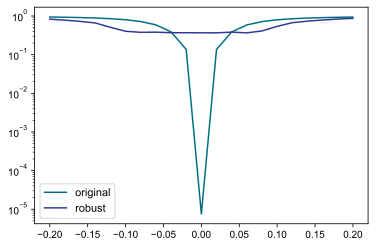

In [123]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots() 
ax.plot(fluc/np.pi,infidelities,label='original')
ax.plot(fluc/np.pi,infidelities_robust,label='robust')
ax.set_yscale('log')
ax.legend()

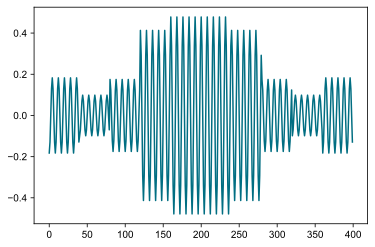

In [64]:
plt.plot(best_total_control1)

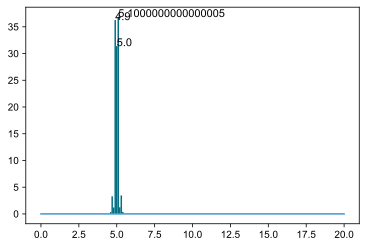

In [124]:
#the pulse for minimum total_error among iterations
best_controls=np.array([qt_c2])
from numpy.fft import rfft,rfftfreq
import matplotlib.pyplot as plt
freq = rfftfreq(len(times), times[1]-times[0])
fourier = np.abs(rfft(best_controls[0]))
freq = rfftfreq(len(times), times[1]-times[0])
max_index = np.argpartition(abs(fourier), -3)[-3:]
fig,ax=plt.subplots()
ax.stem(freq, fourier, markerfmt=' ', label='')
for index in max_index:
    ax.annotate('{}'.format(freq[index]), xy=(freq[index], fourier[index]))

In [100]:
fourier_new=fourier

In [119]:
qt_c2

array([-0.18351865, -0.18351865, -0.18351865, ..., -0.12976728,
       -0.12976728, -0.12976728])

In [103]:
for i in range(len(freq)):
    if np.abs(freq[i]) >= 5.5:
        fourier_new[i]=0
    if np.abs(freq[i]) <= 4.5:
        fourier_new[i]=0

In [109]:
filtered_pulse=np.real(np.fft.ifft(fourier_new))